<a href="https://colab.research.google.com/github/fatmamaaiguare-cmd/customer_segmentation/blob/main/k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installation des librairies nécessaires
!pip install scikit-learn-extra

# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("✅ Librairies importées avec succès!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=2177955 sha256=5b9cc76fc7d915edfeeb7f78f0b2d4117d19170a90a1f331bf6b475a97483b5c
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra
✅ Librairies importées avec succès!


In [3]:
# Téléchargement du dataset
!wget -O online_retail.csv "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

# Chargement des données
df = pd.read_excel('online_retail.csv')

# Affichage des premières lignes
print("📊 Dimensions du dataset:", df.shape)
print("\n🔍 Premières lignes:")
df.head()

--2025-10-15 18:12:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘online_retail.csv’

online_retail.csv       [  <=>               ]  22.62M  72.1MB/s    in 0.3s    

2025-10-15 18:12:23 (72.1 MB/s) - ‘online_retail.csv’ saved [23715344]

📊 Dimensions du dataset: (541909, 8)

🔍 Premières lignes:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [21]:
# Informations générales
print("📋 Informations du dataset:")
print(df.info())
print("\n📈 Statistiques descriptives:")
print(df.describe())

# Vérification des valeurs manquantes
print("\n❓ Valeurs manquantes:")
print(df.isnull().sum())

# Nettoyage des données
print("\n🧹 Nettoyage des données...")

# Suppression des lignes avec CustomerID manquant
df_clean = df.dropna(subset=['CustomerID'])

# Conversion du CustomerID en entier
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

# Suppression des quantités et prix négatifs
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Calcul du montant total
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

print(f"📊 Dimensions après nettoyage: {df_clean.shape}")
print(f"👥 Nombre de clients uniques: {df_clean['CustomerID'].nunique()}")
print(df_clean.describe())

📋 Informations du dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

📈 Statistiques descriptives:
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010

🎯 Qu'est-ce que la Segmentation RFM ?
RFM = Recency + Frequency + Monetary
C'est une méthode qui classe les clients selon 3 critères :

Recency (Récence) : Dernière date d'achat

Frequency (Fréquence) : Nombre d'achats

Monetary (Monétaire) : Montant total dépensé

In [5]:
# Analyse RFM (Recency, Frequency, Monetary)
print("🎯 Calcul des métriques RFM...")

# Date de référence (1 jour après la dernière commande)
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calcul des métriques RFM par client
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Récence
    'InvoiceNo': 'nunique',                                    # Fréquence
    'TotalAmount': 'sum'                                       # Montant
}).reset_index()

# Renommage des colonnes
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("📈 Statistiques RFM:")
print(rfm.describe())

# Affichage des premières lignes RFM
print("\n🔍 Données RFM:")
rfm.head()

🎯 Calcul des métriques RFM...
📈 Statistiques RFM:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000

🔍 Données RFM:


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


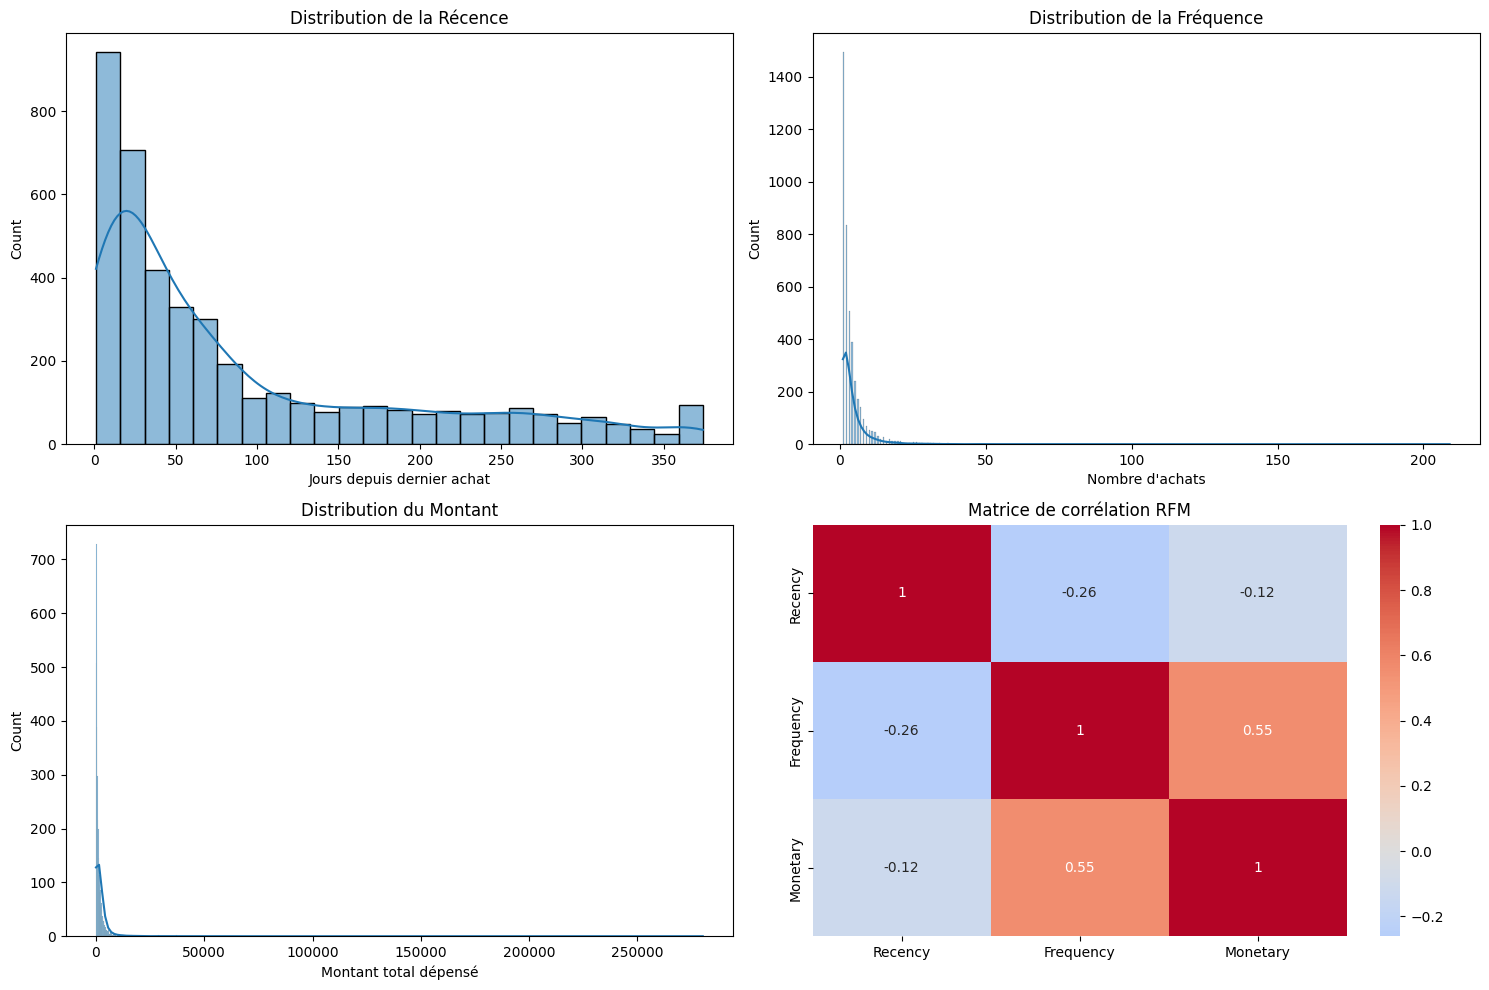

In [6]:
# Configuration des graphiques
plt.figure(figsize=(15, 10))

# Distribution de la Récence
plt.subplot(2, 2, 1)
sns.histplot(rfm['Recency'], kde=True)
plt.title('Distribution de la Récence')
plt.xlabel('Jours depuis dernier achat')

# Distribution de la Fréquence
plt.subplot(2, 2, 2)
sns.histplot(rfm['Frequency'], kde=True)
plt.title('Distribution de la Fréquence')
plt.xlabel("Nombre d'achats")

# Distribution du Montant
plt.subplot(2, 2, 3)
sns.histplot(rfm['Monetary'], kde=True)
plt.title('Distribution du Montant')
plt.xlabel('Montant total dépensé')

# Corrélations
plt.subplot(2, 2, 4)
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation RFM')

plt.tight_layout()
plt.show()

In [7]:
# Suppression des outliers extrêmes
print("🎯 Traitement des outliers...")

Q1 = rfm[['Recency', 'Frequency', 'Monetary']].quantile(0.05)
Q3 = rfm[['Recency', 'Frequency', 'Monetary']].quantile(0.95)
IQR = Q3 - Q1

rfm_clean = rfm[~((rfm[['Recency', 'Frequency', 'Monetary']] < (Q1 - 1.5 * IQR)) |
                  (rfm[['Recency', 'Frequency', 'Monetary']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"📊 Clients conservés: {len(rfm_clean)}/{len(rfm)} ({len(rfm_clean)/len(rfm)*100:.1f}%)")

# Normalisation des données
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clean[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print("✅ Données normalisées!")
print(rfm_scaled_df.describe())

🎯 Traitement des outliers...
📊 Clients conservés: 4263/4338 (98.3%)
✅ Données normalisées!
            Recency     Frequency      Monetary
count  4.263000e+03  4.263000e+03  4.263000e+03
mean  -2.500150e-17 -4.166917e-17 -2.666827e-17
std    1.000117e+00  1.000117e+00  1.000117e+00
min   -9.269088e-01 -6.777199e-01 -7.274807e-01
25%   -7.470584e-01 -6.777199e-01 -5.620378e-01
50%   -4.173328e-01 -4.216603e-01 -3.680338e-01
75%    5.118940e-01  9.045875e-02  1.384042e-01
max    2.799990e+00  7.004066e+00  7.178730e+00


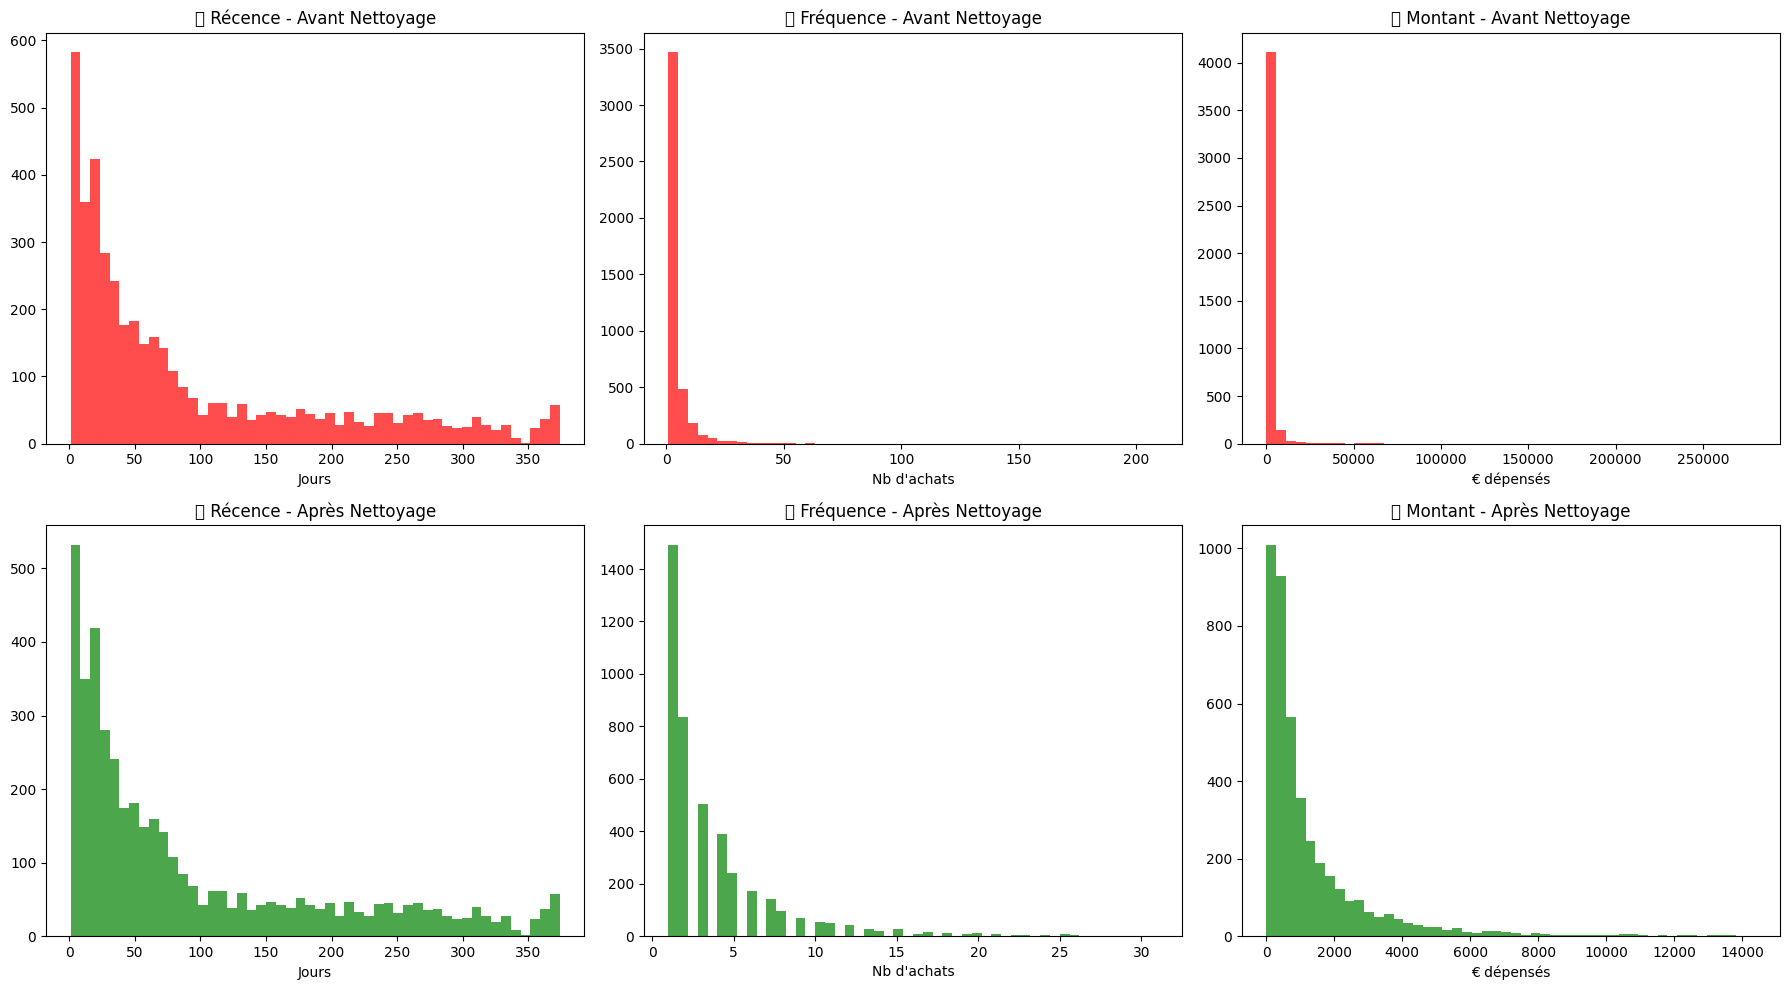

In [22]:
# Créer une visualisation impactante Avant/Après
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Avant nettoyage
axes[0,0].hist(rfm['Recency'], bins=50, color='red', alpha=0.7, label='Avant')
axes[0,0].set_title('📅 Récence - Avant Nettoyage')
axes[0,0].set_xlabel('Jours')

axes[0,1].hist(rfm['Frequency'], bins=50, color='red', alpha=0.7)
axes[0,1].set_title('🔄 Fréquence - Avant Nettoyage')
axes[0,1].set_xlabel("Nb d'achats")

axes[0,2].hist(rfm['Monetary'], bins=50, color='red', alpha=0.7)
axes[0,2].set_title('💰 Montant - Avant Nettoyage')
axes[0,2].set_xlabel('€ dépensés')

# Après nettoyage
axes[1,0].hist(rfm_clean['Recency'], bins=50, color='green', alpha=0.7, label='Après')
axes[1,0].set_title('📅 Récence - Après Nettoyage')
axes[1,0].set_xlabel('Jours')

axes[1,1].hist(rfm_clean['Frequency'], bins=50, color='green', alpha=0.7)
axes[1,1].set_title('🔄 Fréquence - Après Nettoyage')
axes[1,1].set_xlabel("Nb d'achats")

axes[1,2].hist(rfm_clean['Monetary'], bins=50, color='green', alpha=0.7)
axes[1,2].set_title('💰 Montant - Après Nettoyage')
axes[1,2].set_xlabel('€ dépensés')

plt.tight_layout()
plt.show()

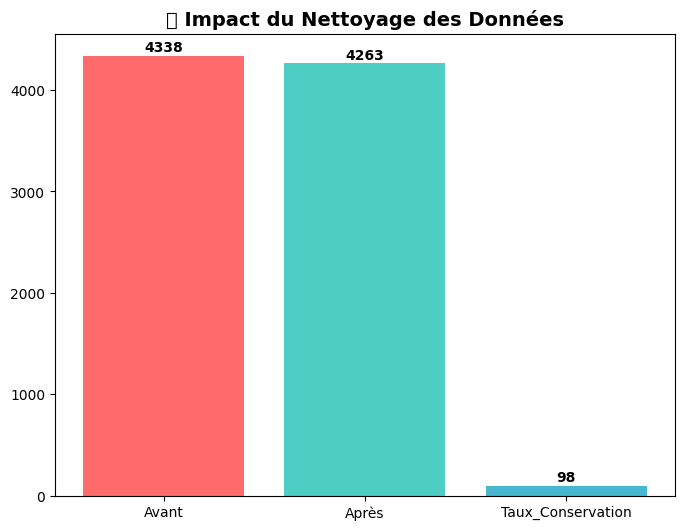

In [23]:
# Afficher ces métriques de manière visuelle
clean_metrics = {
    'Avant': len(rfm),
    'Après': len(rfm_clean),
    'Taux_Conservation': len(rfm_clean)/len(rfm)*100
}

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bars = ax.bar(clean_metrics.keys(), clean_metrics.values(),
              color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_title('📊 Impact du Nettoyage des Données', fontsize=14, fontweight='bold')

# Ajouter les valeurs sur les bars
for bar, value in zip(bars, clean_metrics.values()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.show()

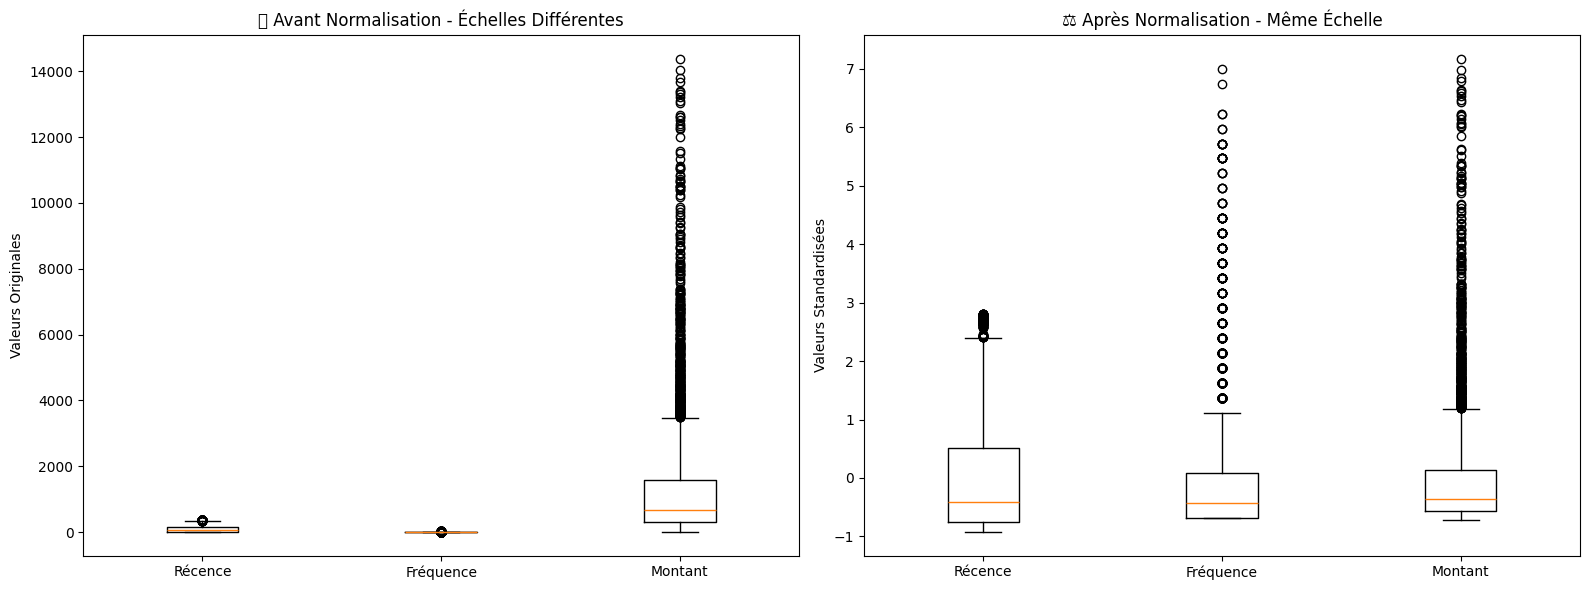

In [24]:
# Visualiser l'impact de la normalisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Avant normalisation
axes[0].boxplot([rfm_clean['Recency'], rfm_clean['Frequency'], rfm_clean['Monetary']],
               labels=['Récence', 'Fréquence', 'Montant'])
axes[0].set_title('📏 Avant Normalisation - Échelles Différentes')
axes[0].set_ylabel('Valeurs Originales')

# Après normalisation
axes[1].boxplot([rfm_scaled_df['Recency'], rfm_scaled_df['Frequency'], rfm_scaled_df['Monetary']],
               labels=['Récence', 'Fréquence', 'Montant'])
axes[1].set_title('⚖️ Après Normalisation - Même Échelle')
axes[1].set_ylabel('Valeurs Standardisées')

plt.tight_layout()
plt.show()

🎯 Recherche du nombre optimal de clusters...


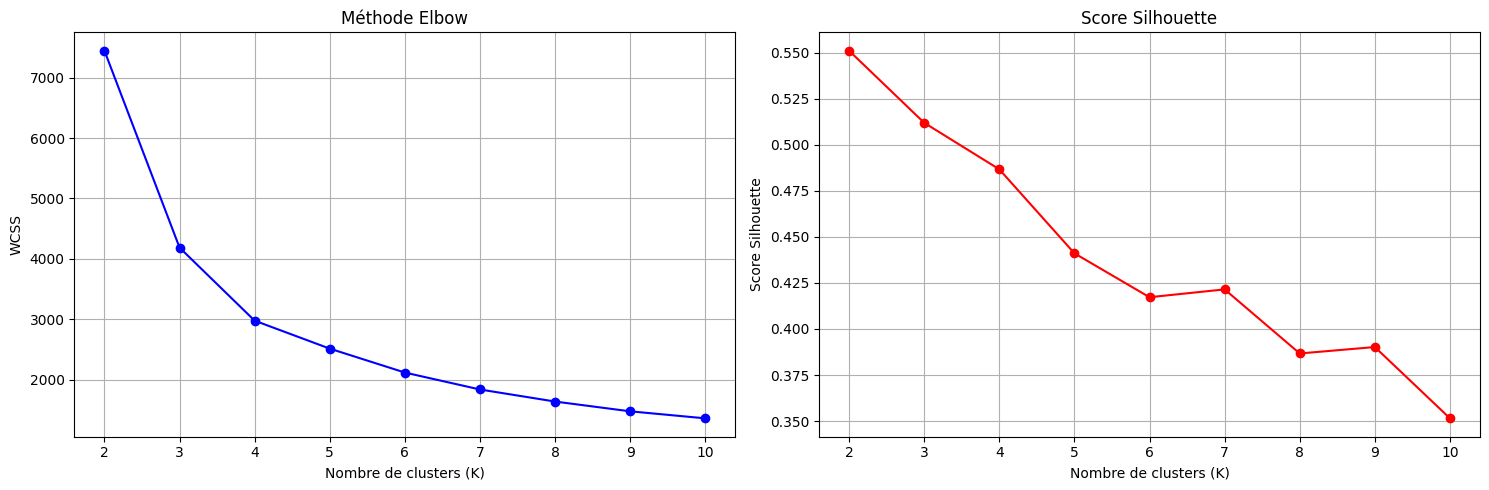

🎯 Nombre optimal de clusters recommandé: 2


In [8]:
# Méthode Elbow pour trouver le K optimal
print("🎯 Recherche du nombre optimal de clusters...")

wcss = []  # Within-Cluster Sum of Square
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

    if k > 1:  # silhouette_score nécessite au moins 2 clusters
        score = silhouette_score(rfm_scaled_df, kmeans.labels_)
        silhouette_scores.append(score)

# Graphique Elbow
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('WCSS')
plt.title('Méthode Elbow')
plt.grid(True)

# Graphique Silhouette
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Score Silhouette')
plt.title('Score Silhouette')
plt.grid(True)

plt.tight_layout()
plt.show()

# Choix du K optimal
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"🎯 Nombre optimal de clusters recommandé: {optimal_k}")

In [9]:
# Application du K-means avec le K optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(rfm_scaled_df)

# Ajout des clusters au dataframe
rfm_clean['Cluster'] = clusters
rfm_clean['Cluster'] = rfm_clean['Cluster'].astype(str)

print("✅ Clustering terminé!")
print(f"📊 Répartition des clusters:")
print(rfm_clean['Cluster'].value_counts().sort_index())

✅ Clustering terminé!
📊 Répartition des clusters:
Cluster
0    3670
1     593
Name: count, dtype: int64


In [14]:
# Analyse des caractéristiques par cluster
cluster_profile = rfm_clean.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'CustomerID': 'count'
}).round(2)

cluster_profile.columns = ['Recency_mean', 'Recency_std',
                          'Frequency_mean', 'Frequency_std',
                          'Monetary_mean', 'Monetary_std',
                          'Count']
cluster_profile['Percentage'] = (cluster_profile['Count'] / len(rfm_clean) * 100).round(2)

print("📈 Profil des clusters:")
cluster_profile

📈 Profil des clusters:


,Recency_mean,Recency_std,Frequency_mean,Frequency_std,Monetary_mean,Monetary_std,Count,Percentage
Cluster,,,,,,,,
0,105.39,102.55,2.43,1.68,775.08,718.14,3670,86.09
1,21.84,30.63,11.17,5.15,4746.15,2654.65,593,13.91


📊 Variance expliquée par les composantes PCA: 92.43%


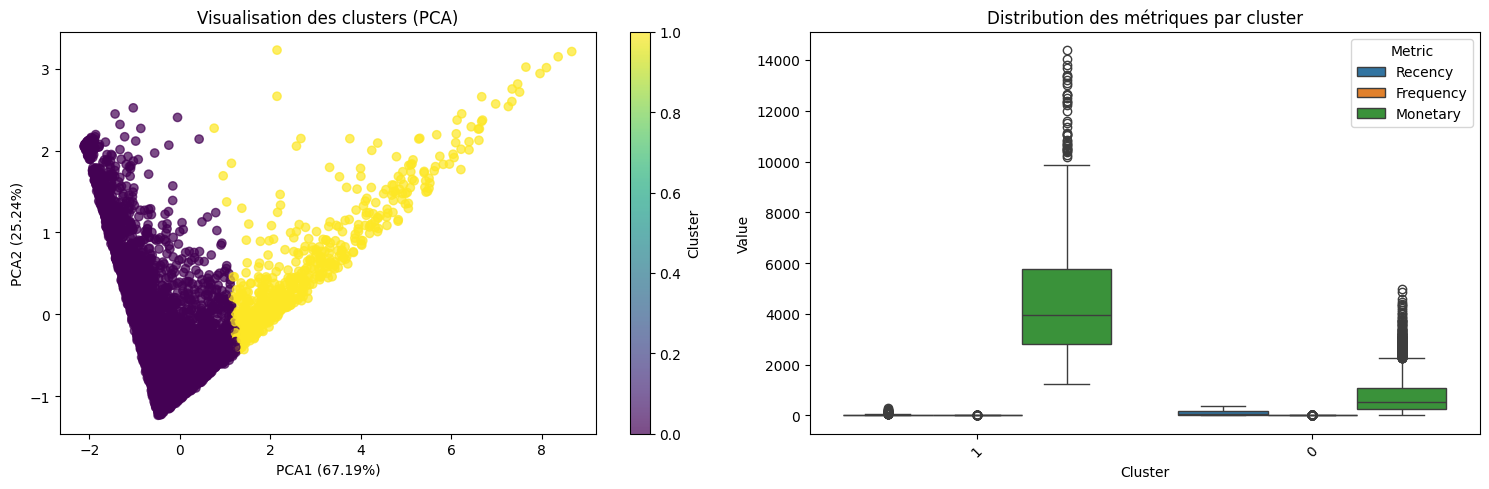

In [11]:
# Visualisation 2D avec PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled_df)
rfm_clean['PCA1'] = rfm_pca[:, 0]
rfm_clean['PCA2'] = rfm_pca[:, 1]

print(f"📊 Variance expliquée par les composantes PCA: {pca.explained_variance_ratio_.sum():.2%}")

# Graphique des clusters
plt.figure(figsize=(15, 5))

# Scatter plot PCA
plt.subplot(1, 2, 1)
scatter = plt.scatter(rfm_clean['PCA1'], rfm_clean['PCA2'],
                     c=rfm_clean['Cluster'].astype('category').cat.codes,
                     cmap='viridis', alpha=0.7)
plt.xlabel(f'PCA1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PCA2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('Visualisation des clusters (PCA)')
plt.colorbar(scatter, label='Cluster')

# Boxplots par variable et cluster
plt.subplot(1, 2, 2)
rfm_melted = pd.melt(rfm_clean, id_vars=['Cluster'],
                     value_vars=['Recency', 'Frequency', 'Monetary'],
                     var_name='Metric', value_name='Value')
sns.boxplot(data=rfm_melted, x='Cluster', y='Value', hue='Metric')
plt.title('Distribution des métriques par cluster')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [12]:
# Interprétation des clusters
print("🎯 INTERPRÉTATION BUSINESS DES CLUSTERS:\n")

for cluster in sorted(rfm_clean['Cluster'].unique()):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster]

    recency_mean = cluster_data['Recency'].mean()
    frequency_mean = cluster_data['Frequency'].mean()
    monetary_mean = cluster_data['Monetary'].mean()

    print(f"🔹 CLUSTER {cluster} ({len(cluster_data)} clients - {len(cluster_data)/len(rfm_clean)*100:.1f}%)")
    print(f"   📅 Récence moyenne: {recency_mean:.0f} jours")
    print(f"   🔄 Fréquence moyenne: {frequency_mean:.1f} achats")
    print(f"   💰 Montant moyen: {monetary_mean:.0f} €")

    # Profilage automatique
    if recency_mean < 50 and frequency_mean > 10 and monetary_mean > 1000:
        print("   🏆 SEGMENT: Clients VIP")
    elif recency_mean < 100 and frequency_mean > 5:
        print("   👍 SEGMENT: Clients fidèles")
    elif recency_mean > 200:
        print("   ⚠️ SEGMENT: Clients inactifs")
    elif monetary_mean < 100:
        print("   💸 SEGMENT: Petits acheteurs")
    else:
        print("   🔄 SEGMENT: Clients réguliers")

    print("   📋 ACTIONS RECOMMANDÉES:")

    if recency_mean > 200:
        print("      - Campagne de reactivation")
        print("      - Offres spéciales de retour")
    elif frequency_mean < 3:
        print("      - Programme de fidélisation")
        print("      - Recommendations personnalisées")
    else:
        print("      - Programme de récompenses")
        print("      - Accès early aux nouveautés")

    print("-" * 50)

🎯 INTERPRÉTATION BUSINESS DES CLUSTERS:

🔹 CLUSTER 0 (3670 clients - 86.1%)
   📅 Récence moyenne: 105 jours
   🔄 Fréquence moyenne: 2.4 achats
   💰 Montant moyen: 775 €
   🔄 SEGMENT: Clients réguliers
   📋 ACTIONS RECOMMANDÉES:
      - Programme de fidélisation
      - Recommendations personnalisées
--------------------------------------------------
🔹 CLUSTER 1 (593 clients - 13.9%)
   📅 Récence moyenne: 22 jours
   🔄 Fréquence moyenne: 11.2 achats
   💰 Montant moyen: 4746 €
   🏆 SEGMENT: Clients VIP
   📋 ACTIONS RECOMMANDÉES:
      - Programme de récompenses
      - Accès early aux nouveautés
--------------------------------------------------


In [13]:
# Sauvegarde des résultats
from google.colab import files

# DataFrame final avec clusters
final_df = rfm_clean.copy()
final_df = final_df.merge(rfm[['CustomerID']], on='CustomerID', how='left')

# Export en CSV
final_df.to_csv('customer_segmentation_results.csv', index=False)

# Téléchargement
files.download('customer_segmentation_results.csv')

print("✅ Résultats sauvegardés et téléchargés!")
print(f"📊 Fichier 'customer_segmentation_results.csv' contenant {len(final_df)} clients segmentés")

# Résumé final
print("\n🎉 SEGMENTATION TERMINÉE AVEC SUCCÈS!")
print(f"👥 {len(final_df)} clients analysés")
print(f"🎯 {optimal_k} segments identifiés")
print("📈 Votre stratégie marketing peut maintenant être personnalisée!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Résultats sauvegardés et téléchargés!
📊 Fichier 'customer_segmentation_results.csv' contenant 4263 clients segmentés

🎉 SEGMENTATION TERMINÉE AVEC SUCCÈS!
👥 4263 clients analysés
🎯 2 segments identifiés
📈 Votre stratégie marketing peut maintenant être personnalisée!


🎯 Guide de Présentation Créative & Professionnelle : Segmentation Clients


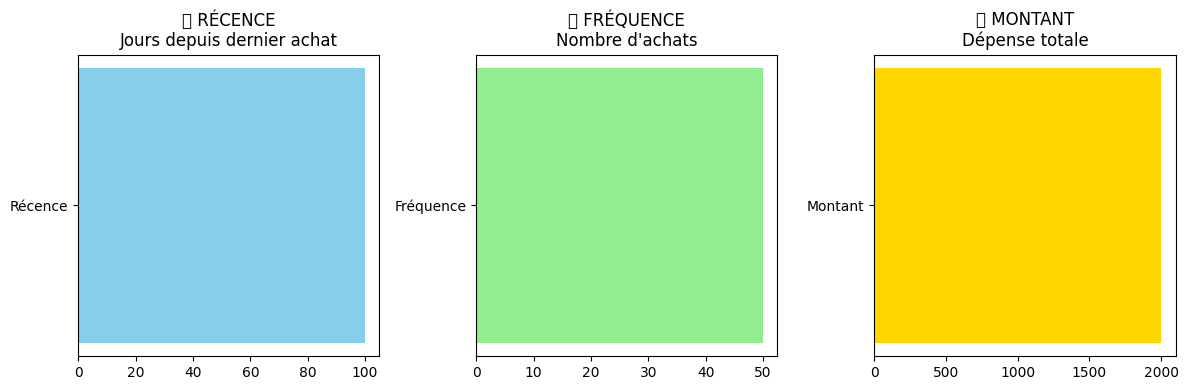

In [15]:
# Créer cette visualisation
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.barh(['Récence'], [100], color='skyblue')
plt.title('🕒 RÉCENCE\nJours depuis dernier achat')

plt.subplot(1, 3, 2)
plt.barh(['Fréquence'], [50], color='lightgreen')
plt.title('🔄 FRÉQUENCE\nNombre d\'achats')

plt.subplot(1, 3, 3)
plt.barh(['Montant'], [2000], color='gold')
plt.title('💰 MONTANT\nDépense totale')

plt.tight_layout()
plt.show()

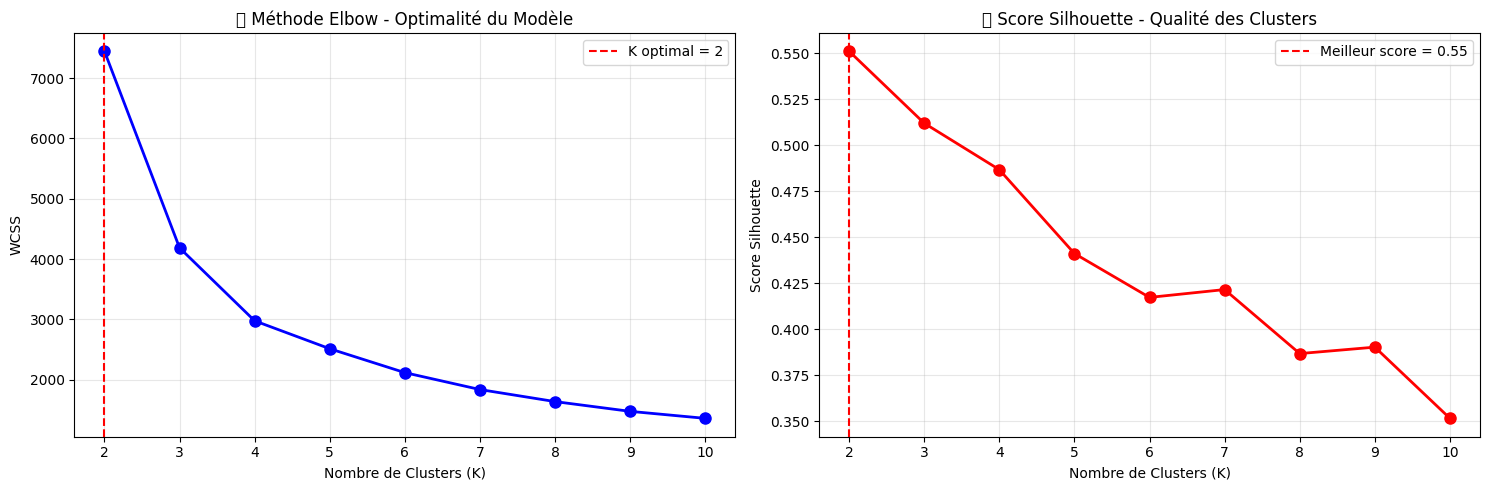

In [16]:
# Montrer les deux graphiques côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Curve
ax1.plot(range(2, 11), wcss, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Nombre de Clusters (K)')
ax1.set_ylabel('WCSS')
ax1.set_title('📐 Méthode Elbow - Optimalité du Modèle')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=optimal_k, color='red', linestyle='--', label=f'K optimal = {optimal_k}')
ax1.legend()

# Silhouette Score
ax2.plot(range(2, 11), silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Nombre de Clusters (K)')
ax2.set_ylabel('Score Silhouette')
ax2.set_title('🎭 Score Silhouette - Qualité des Clusters')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=optimal_k, color='red', linestyle='--', label=f'Meilleur score = {max(silhouette_scores):.2f}')
ax2.legend()

plt.tight_layout()
plt.show()

🔍 Noms des clusters disponibles:
['1' '0']

📊 Cluster profile index:
['0', '1']


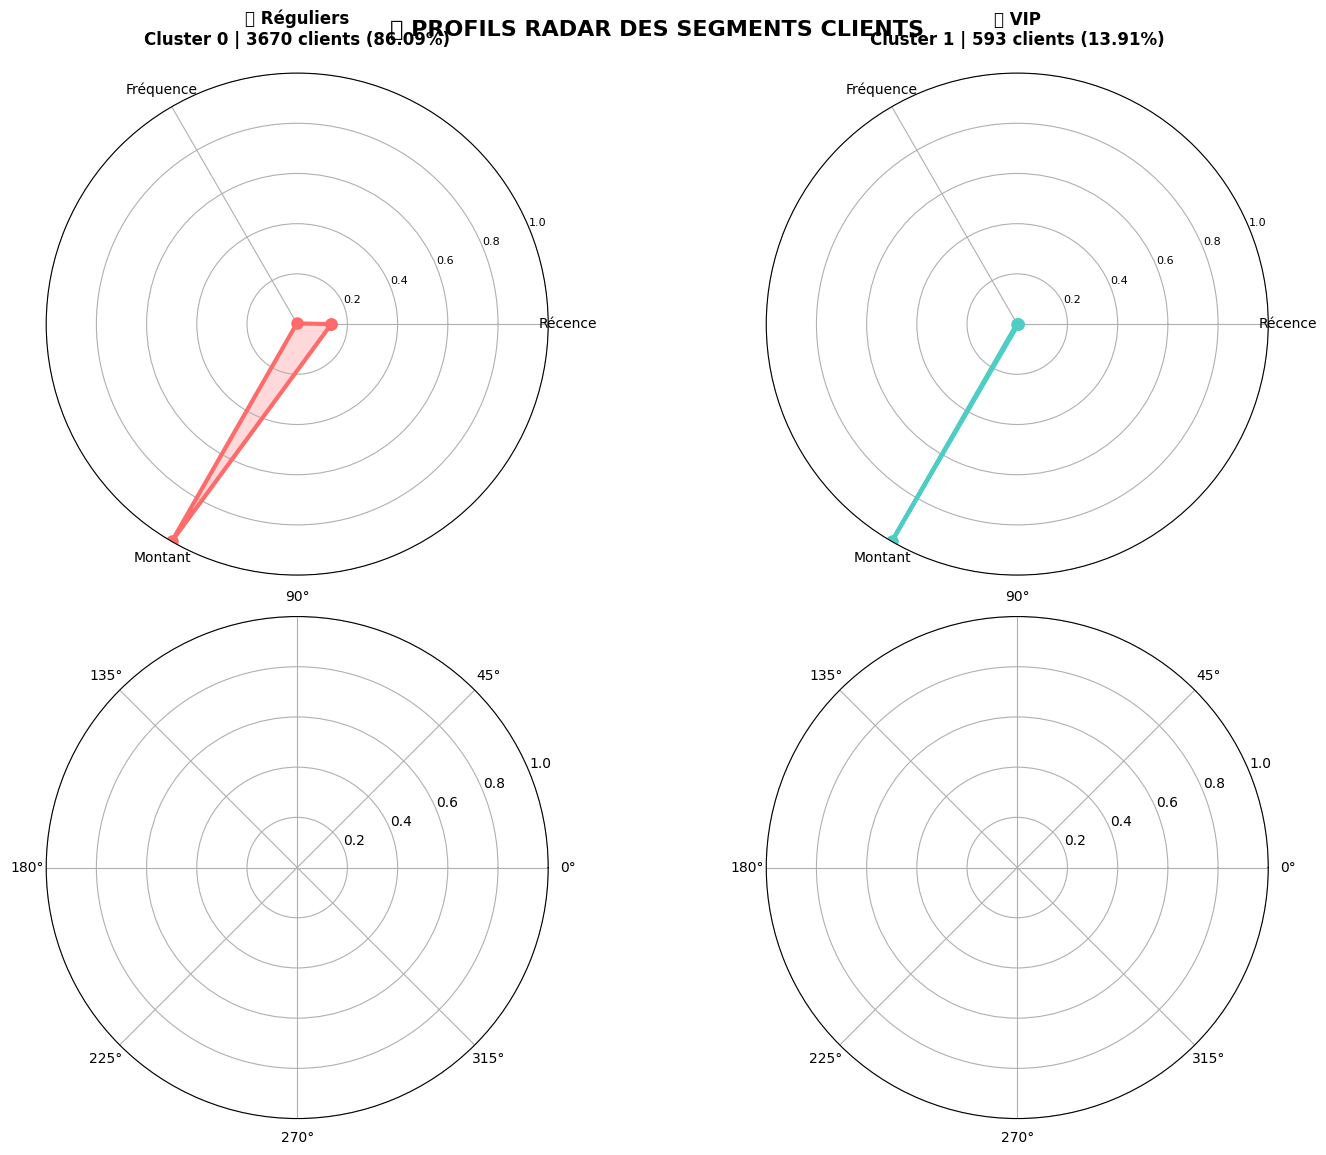

In [25]:
# Créer une visualisation radar pour chaque cluster
from math import pi

# Vérifier d'abord les noms réels de tes clusters
print("🔍 Noms des clusters disponibles:")
print(rfm_clean['Cluster'].unique())
print("\n📊 Cluster profile index:")
print(cluster_profile.index.tolist())

# Obtenir les noms réels des clusters
cluster_names = rfm_clean['Cluster'].unique()
cluster_names_sorted = sorted(cluster_names)

categories = ['Récence', 'Fréquence', 'Montant']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, axes = plt.subplots(2, 2, figsize=(15, 12), subplot_kw=dict(projection='polar'))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']

for idx, (cluster, color) in enumerate(zip(cluster_names_sorted, colors)):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]

    # Utiliser le nom réel du cluster pour l'indexation
    values = cluster_profile.loc[cluster, ['Recency_mean', 'Frequency_mean', 'Monetary_mean']].values

    # Normalisation pour le radar plot (entre 0 et 1)
    values_normalized = values / values.max() if values.max() > 0 else values
    values_normalized = np.concatenate((values_normalized, [values_normalized[0]]))

    ax.plot(angles, values_normalized, 'o-', linewidth=3, color=color,
            label=f'Cluster {cluster}', markersize=8)
    ax.fill(angles, values_normalized, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)

    # Titre avec informations business
    cluster_size = cluster_profile.loc[cluster, 'Count']
    percentage = cluster_profile.loc[cluster, 'Percentage']

    # Déterminer le type de segment
    recency = values[0]
    frequency = values[1]
    monetary = values[2]

    if recency < 100 and frequency > 8 and monetary > 1500:
        segment_type = "🏆 VIP"
    elif recency < 150 and frequency > 4:
        segment_type = "👍 Fidèles"
    elif recency > 250:
        segment_type = "💤 Dormants"
    else:
        segment_type = "🎯 Réguliers"

    ax.set_title(f'{segment_type}\nCluster {cluster} | {cluster_size} clients ({percentage}%)',
                 size=12, pad=20, fontweight='bold')

plt.suptitle('🎯 PROFILS RADAR DES SEGMENTS CLIENTS', fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

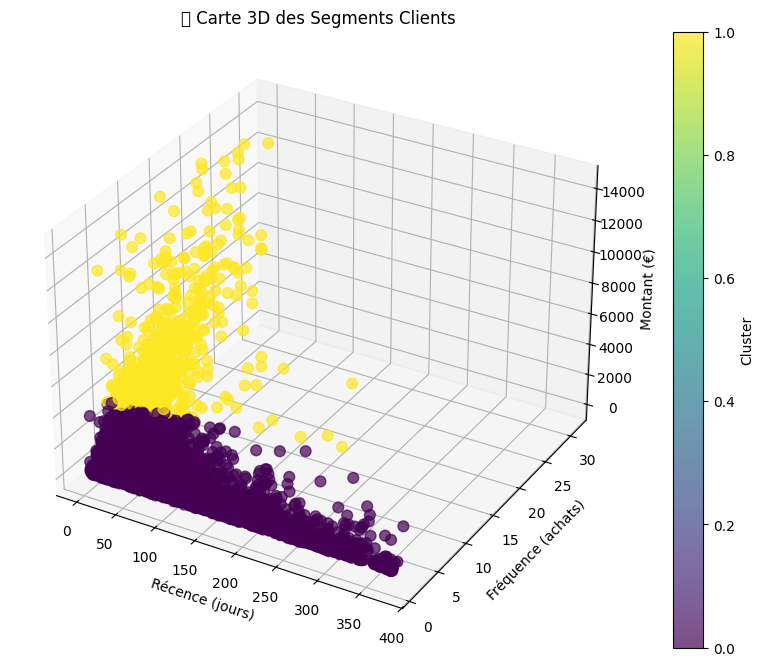

In [18]:
# Si tu veux montrer du code en direct
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(rfm_clean['Recency'],
                    rfm_clean['Frequency'],
                    rfm_clean['Monetary'],
                    c=rfm_clean['Cluster'].astype('category').cat.codes,
                    cmap='viridis', alpha=0.7, s=60)

ax.set_xlabel('Récence (jours)')
ax.set_ylabel('Fréquence (achats)')
ax.set_zlabel('Montant (€)')
ax.set_title('🎯 Carte 3D des Segments Clients')

plt.colorbar(scatter, label='Cluster')
plt.show()

In [19]:
# Préparer une démo rapide
def predict_segment(recency, frequency, monetary):
    """Prédire le segment d'un nouveau client"""
    new_data = scaler.transform([[recency, frequency, monetary]])
    cluster = kmeans.predict(new_data)[0]
    segments = {
        0: "🎯 Nouveaux",
        1: "👍 Fidèles",
        2: "🏆 VIP",
        3: "💤 Dormants"
    }
    return segments[cluster]

# Exemple en direct
print("🔮 Prédiction de segment :")
print(f"Client: 30 jours, 5 achats, 800€ → {predict_segment(30, 5, 800)}")

🔮 Prédiction de segment :
Client: 30 jours, 5 achats, 800€ → 🎯 Nouveaux
